# Exercise 1

### Note:
In this section I am exploring UNFCCC COP Decisions within each year. From COP 1 in 1995 to COP 25 in 2019. 

In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [15]:
with open('text_by_year_raw.pickle', 'rb') as handle:
    decsDF = pickle.load(handle)

In [16]:
decsDF.head()

,year,texts
0,1,FCCC/CP/1995/7/Add.1EnglishPage 4I. DECISIONS...
1,2,FCCC/CP/1996/15/Add.1EnglishPage 4I. DECISION...
2,3,FCCC/CP/1997/7/Add.1EnglishPage 4I. DECISIONS...
3,4,FCCC/CP/1998/16/Add.1EnglishPage 4I. DECISION...
4,5,FCCC/CP/1999/6/Add.1EnglishPage 4Decision 1/CP...


In [17]:
decsDF.shape

(25, 2)

In [19]:
import sklearn.feature_extraction
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

#Now normalize the texts
vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
vects_incidence = vectorizer.fit_transform(decsDF['texts'])

In [22]:
vects_incidence.shape

(25, 17281)

In [24]:
import time
#Now begin to create network by word occurance

start = time.time()
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((vectorizer.get_feature_names()[i] for i in range(vects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(vects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, vectorizer.get_feature_names()[w], {'weight' : vects_incidence[d, w]}) for d, w in zip(*vects_incidence.nonzero())))

print('Time elapsed:',time.time()-start)



Time elapsed: 1268.2329757213593


In [25]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [26]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 25
Number of edges: 300
Average degree:  24.0000


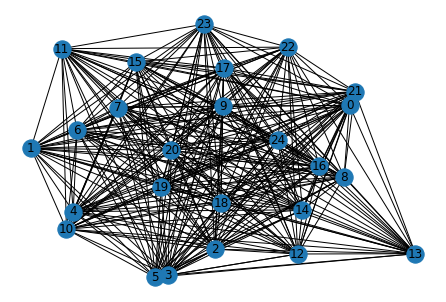

In [28]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

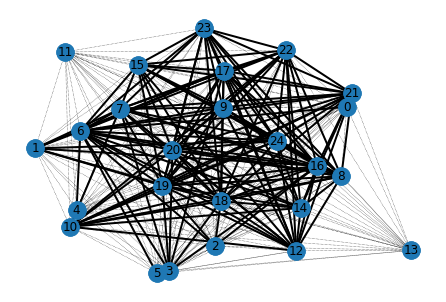

In [29]:

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

### Note:
Here we see that some of the years are closely related to each other, some are not. This may indicate that within different years, COP's focus are different, meaning that UNFCCC and different states are pushing for different agenda.
One extremely interesting finding is that COP 21(Node 20) is at the very center of the graph. COP21 in 2015 is when Paris Agreement is passed. Paris Agreement is suppose to carry on the undone work of Kyoto Protocol, which is understably why the content has highest connections.

In [30]:
#First normalize the texts
decsDF['tokenized_sents'] = decsDF['texts'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
decsDF['normalized_sents'] = decsDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [31]:
with open('text_by_year.pickle', 'wb') as handle:
    pickle.dump(decsDF, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [36]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [159]:
g = wordCooccurrence(decsDF['normalized_sents'].sum())
print(nx.info(g))

In [152]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 17002
Number of edges: 820783
Average degree:  96.5513


In [136]:
import copy
gg = copy.deepcopy(g)

In [137]:
np.median([d['weight'] for n1, n2, d in g.edges(data = True)])

1.0

In [138]:
def get_edge_attributes(G, name):
    # ...
    edges = G.edges(data=True)
    return dict( (x[:-1], x[-1][name]) for x in edges if name in x[-1] )

In [139]:
g_att = get_edge_attributes(g, 'weight')

In [140]:
sum(g_att.values())/len(g_att)

5.348865656330601

In [141]:
max(g_att.values())

8604.0

In [144]:
trans_w = []
for k, v in g_att.items():
    if 'transparency' in k:
        trans_w.append(v)

In [146]:
np.mean(trans_w)

5.113513513513514

In [150]:
trans_w

[1.0,
 2.0,
 1.0,
 2.0,
 17.0,
 2.0,
 8.0,
 1.0,
 2.0,
 5.0,
 3.0,
 1.0,
 3.0,
 25.0,
 1.0,
 2.0,
 1.0,
 17.0,
 1.0,
 5.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 5.0,
 2.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 3.0,
 3.0,
 13.0,
 1.0,
 1.0,
 3.0,
 4.0,
 1.0,
 5.0,
 2.0,
 1.0,
 1.0,
 17.0,
 6.0,
 2.0,
 1.0,
 5.0,
 3.0,
 1.0,
 2.0,
 5.0,
 5.0,
 2.0,
 1.0,
 2.0,
 1.0,
 13.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 6.0,
 5.0,
 2.0,
 1.0,
 1.0,
 12.0,
 31.0,
 1.0,
 2.0,
 1.0,
 18.0,
 2.0,
 4.0,
 6.0,
 1.0,
 1.0,
 6.0,
 15.0,
 1.0,
 16.0,
 7.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 10.0,
 7.0,
 1.0,
 3.0,
 4.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 15.0,
 2.0,
 4.0,
 27.0,
 1.0,
 5.0,
 22.0,
 3.0,
 1.0,
 4.0,
 3.0,
 2.0,
 29.0,
 7.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 4.0,
 4.0,
 1.0,
 4.0,
 6.0,
 5.0,
 1.0,
 1.0,
 2.0,
 4.0,
 2.0,
 1.0,
 4.0,
 1.0,
 15.0,
 6.0,
 7.0,
 1.0,
 4.0,
 1.0,

In [151]:
g = gg

In [153]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 17002
Number of edges: 820783
Average degree:  96.5513


In [154]:
#Seems alright. Then we remove those edges whose weight is low and those isolated nodes
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] > 6])
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] < 5])
g.remove_nodes_from(list(nx.isolates(g)))

In [155]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4614
Number of edges: 40135
Average degree:  17.3971


In [127]:
np.quantile(list(g_att.values()), 0.85)

5.0

In [89]:
import seaborn as sns

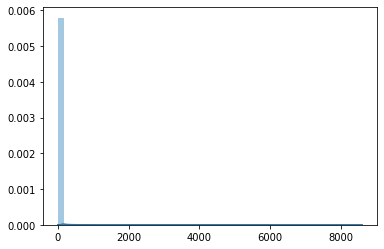

In [90]:
sns.distplot(list(g_att.values()))

### Note:
 Visualing the distribution of the weight to see what can be removed. 

In [156]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
#giant = connected_component_subgraphs(g)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 4576
Number of edges: 40101
Average degree:  17.5267


too big to plot.

In [160]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 17002
Number of edges: 820783
Average degree:  96.5513


In [161]:
g_att = get_edge_attributes(g, 'weight')

In [172]:
np.quantile(list(g_att.values()), 0.9999)

1067.1398000001209

In [173]:
#Remove those edges whose weight is low and those isolated nodes
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1067])
#g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] < 5])
g.remove_nodes_from(list(nx.isolates(g)))

In [174]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 46
Number of edges: 83
Average degree:   3.6087


In [175]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
#giant = connected_component_subgraphs(g)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 39
Number of edges: 79
Average degree:   4.0513


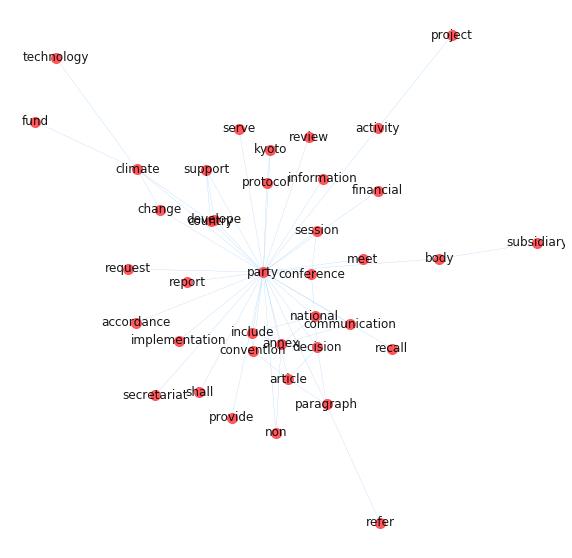

In [176]:
#Plot
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

### Note:
For this assignemnt, I have visualized the graph with highest weighted edges. This ofcourse is not too meaningful for investigating the discourse change within the COP decisions from different years. We see that words like party and conference and session basically take over the center.

In [177]:
#words that are completely connected
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))


party, annex, include, national


In [184]:
g = wordCooccurrence(decsDF['normalized_sents'].sum())

print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 17002
Number of edges: 820783
Average degree:  96.5513


In [185]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] > 6])
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] < 5])
g.remove_nodes_from(list(nx.isolates(g)))

In [208]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4614
Number of edges: 40135
Average degree:  17.3971


In [209]:
type(g.neighbors('transparency'))

dict_keyiterator

In [210]:
#Now lets look at words that are directly related to transparency
Neighbors = g.neighbors('transparency')
gneighbors = g.subgraph(Neighbors)
print(nx.info(gneighbors))

Name: 
Type: Graph
Number of nodes: 73
Number of edges: 205
Average degree:   5.6164


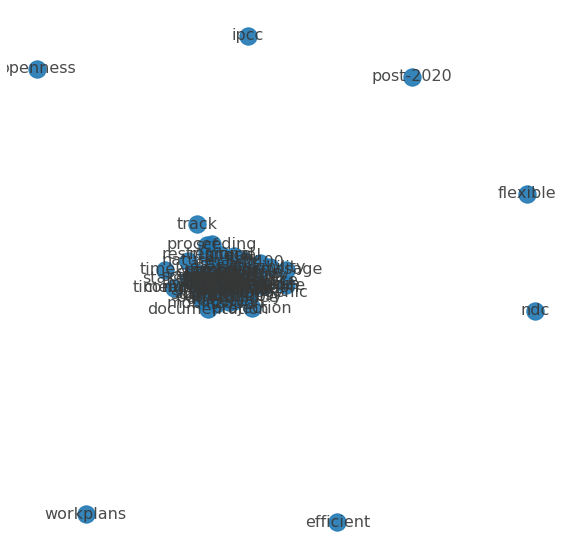

In [187]:
#Plot it. 
layout = nx.spring_layout(gneighbors, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in gneighbors.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gneighbors.edges(data = True)))
nx.draw(gneighbors, ax = ax, pos = layout, labels = {n:n for n in gneighbors.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gneighbors.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [203]:
unfrozen_graph = nx.Graph(gneighbors)
nx.is_frozen(unfrozen_graph)
unfrozen_graph.remove_nodes_from(list(nx.isolates(unfrozen_graph)))
unfrozen_graph.remove_node('workplans')

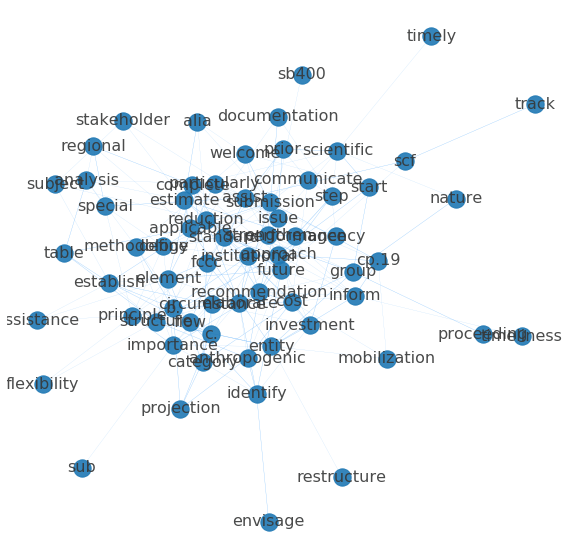

In [204]:
#Plot it. 
layout = nx.spring_layout(unfrozen_graph, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in unfrozen_graph.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in unfrozen_graph.edges(data = True)))
nx.draw(unfrozen_graph, ax = ax, pos = layout, labels = {n:n for n in unfrozen_graph.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in unfrozen_graph.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

### Note:
Here I have chosen to look at one specific word 'transparency', which some have argued is becoming more and more important. We can see some of the words that are highly associated with it: stakeholder, proceedings, identify, methodology and so on. For future work, this can be performed for every year to see how the neighbors change.

# Exercise 2